# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Exploratory Data Analysis (EDA) of the Teranet dataset
# Pairplots of Teranet variables

---

This notebook describes _Step 3: Explore_  of OSEMN methodology performed on the Teranet dataset.

Previous steps included: 

**Step 2: Scrub:**

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

* **Step 2.3:** addition of new attributes to the Teranet dataset

* during Step 2.3, **two versions of the Teranet dataset were produced**:

    * one where `consideration_amt` was left unmodified
    
    * one where `consideration_amt` < 10'000 CAD was reset to NaN and these records were removed from the dataset (1,615,178 records (23.74% of the total) have been removed. 5,188,513 records remain in the Teranet dataset).

New attributes were added to both versions of the Teranet dataset:
 
* surrogate key:

    * `transaction_id`: unique identifier for each Teranet transaction 
    
Essentially, a simple range index, which represents the row number of a record in the full Teranet dataset (filtered to include only GTHA records), ordered by date (from earliest to latest) and `pin`
    
* attributes for display

    * `date_disp`: `registration_date` converted to `datetime.date` data type to exclude the timestamp (original `registration_date` is stored in NumPy's `datetime64` format to allow more efficient datetime operations)
    
    * `price_disp`: `consideration_amt` formatted to include thousands separator (_e.g.,_ '3,455,122') and stored as a string, for display purposes
    
* attributes for record grouping
    
    * `year`: year parsed from `registration_date`, to simplify record grouping
    
    * `3year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2014-2016'), to simplify record grouping
    
    * `5year`: `registration_date` parsed for 5-year intervals (_e.g.,_ '2012-2016'), to simplify record grouping
    
    * `10year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2007-2017'), to simplify record grouping
    
    * `xy`: `x` and `y` coordinates concatenated together (_e.g.,_ '43.098324_-79.234235'), can be used to identify and group records by their coordinate pairs
    
* correction of `consideration_amt` for inflation    
    
    * `price_infl`: `consideration_amt` corrected for inflation
    
* exploratory attributes

    * `pin/xy_total_sales`: total records for this `pin`/`xy`

    * `pin/xy_prev_sales`: previous records from this `pin`/`xy` (not counting current transaction)

    * `pin/xy_price_cum_sum`: cumulative price of all records to date from this `pin`/`xy`

    * `pin/xy_price_pct_change`: price percentage change compared to previous record from this `pin`/`xy`

    * `price_da_pct_change`: price percentage change compared to previous record from this DA (by `da_id`)

    * `pin/xy_years_since_last_sale`: years since last sale from this `pin`/`xy`

    * `da_days_since_last_sale`, `da_years_since_last_sale`: days or years since last sale from this DA (by `da_id`)

    * `sale_next_6m/1y/3y`: "looks into the future" to see whether there is another transaction from this `pin`/`xy` within the given time horizon (6 months, 1 year, 3 years)

    * for details, see `notebooks/2.scrub/2.3_teranet_new_cols.ipynb` and `notebooks/2.scrub/2.3_teranet_nonan_new_cols.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 3: Explore_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

## Import dependencies

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from time import time

sns.set()

In [34]:
import sys

sys.path.append('../../src')

from plot_utils import grouped_boxplot, plot_hist

In [46]:
def grouped_boxplot(df, year=None, max_price=None, figsize=(12, 12),
                    plot_col='price_2016', group_col='csdname', hue_col=None, vert=False,
                    ylabel='Municipality', xlabel='Consideration amount (in 2016 CAD)',
                    x_ticks_rot=0,
                    form_x=False, form_y=False, title=None, output='show'):
    """
    plot a grouped boxplot of column 'plot_col' in DataFrame 'df' grouped by column 'group_col'
    :param df: pandas DataFrame
    DataFrame with variables to be plotted
    :param year: int
    take Teranet subset from this year
    :param max_price: float
    include only Teranet records with price_2016 < max_price
    :param plot_col: string
    name of the column to plot
    :param group_col: string
    name of the column to group Teranet records by
    :param title: string
    title of the plot
    :param output: string, must be 'save' or 'show'
    :return: None, plots a boxplot
    """
    # create figure and axis
    f, ax = plt.subplots(1, figsize=figsize)
    
    # filter records for year and max price
    if year:
        df = df.query('year == {0}'.format(year))
    if max_price:
        df = df.query('price_2016 < {0}'.format(max_price))
    
    # plot the boxplot
    df.boxplot(column=plot_col, by=group_col, vert=vert, ax=ax)
#    if vert:
#        sns.boxplot(data=df, x=plot_col, y=group_col, hue=hue_col, ax=ax)
#    else:
#        sns.boxplot(data=df, x=group_col, y=plot_col, hue=hue_col, ax=ax)
    
    # format axes
    if form_x:
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if form_y:
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # set axis parameters
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_xlim(0, max_price)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=x_ticks_rot)
    if title:
        ax.set_title(title, fontsize=18)
    plt.suptitle("")
    
    # save or show the result
    if output == 'show':
        plt.show()
    elif output == 'save':
        f.savefig('results/plots/boxplots/teranet_{0}_{1}_by_{2}.png'
                  .format(year, plot_col, group_col), dpi=200, bbox_inches='tight')
    else:
        raise ValueError("parameter 'output' for function 'grouped_boxplot' must be either 'show' or 'save'")
    plt.close(f)

In [4]:
def plot_hist(ser, form_x=False, form_y=False, figsize=(14, 6), kde=False, x_label=None,
              plot_mean=True, plot_median=True, mean_xlift=1.1, med_xlift=0.7, sdev=True, sdev_xlift=1.3,
              title='Distribution', title_size=20, 
              x_tick_size=14, y_tick_size=14, x_lab_size=16, y_lab_size=16, mean_med_size=14,
              act='show', save_path='distribution.png', dpi=300, save_only=True):
    
    # create figure and axis
    f, ax = plt.subplots(1, figsize=figsize)
    
    # plot distribution
    sns.distplot(ser, kde=kde, ax=ax)
    
    # plot mean of the series
    if plot_mean:
        mean = ser.mean()
        ax.axvline(mean, linestyle='--', color='deeppink')
        ax.text(mean * mean_xlift, 0, 'Mean: {0:,.2f}'.format(mean), fontsize=mean_med_size, rotation=90)
    # plot median of the series
    if plot_median:
        median = ser.median()
        ax.axvline(median, linestyle='--', color='teal')
        ax.text(median * med_xlift, 0, 'Median: {0:,.2f}'.format(median), fontsize=mean_med_size, rotation=90)
    # print standard deviation of the series
    if sdev:
        ax.text(mean * sdev_xlift, 0, 'StDev: {0:,.2f}'.format(ser.std()), fontsize=mean_med_size, rotation=90)
        
    # format axes
    if form_x:
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if form_y:
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # configure axes parameters
    ax.set_title(title, fontsize=title_size)
    plt.xticks(fontsize=x_tick_size)
    plt.yticks(fontsize=y_tick_size)
    if kde:
        ax.set_ylabel('Kernel density estimation (KDE)', fontsize=y_lab_size)
    else:
        ax.set_ylabel('Count of records', fontsize=y_lab_size)
        
    if x_label:
        ax.set_xlabel(x_label, fontsize=x_lab_size)
    
    # save or show results
    if act == 'show':
        plt.show()
    elif act == 'save':
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print("Saved output plot to", save_path)
        if save_only:
            plt.close(f)

## Load Teranet data, join GTA land use codes
### Load GTA land use codes

In [36]:
teranet_path = '../../data/teranet/'
landuse_code_path = teranet_path + 'ParcelLandUse/GTA/'
os.listdir(landuse_code_path)

['GTA_land_use_code.txt',
 'GTAparcel16LU12.shx',
 'with_epoi',
 'GTAparcel16LU12.prj',
 'gta_land_use_code.csv',
 'GTAparcel16LU12.cpg',
 'GTAparcel16LU12.shp',
 'GTAparcel16LU12.dbf']

In [37]:
land_use_codes = pd.read_csv(landuse_code_path + 'gta_land_use_code.csv')
land_use_codes.head()

,landuse,code
0,0,Uncoded
1,1,Single Detached House
2,2,Commercial/Shopping
3,3,Industrial/Employment Lands
4,4,Government/Institutional


### Load Teranet, join GTA land use, generate GeoDataFrame

In [38]:
# load DataFrame with Teranet records
t = time()
df = pd.read_csv(teranet_path + '3_Teranet_nonan_new_cols.csv',
                 parse_dates=['registration_date'])
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

# join GTA land use codes
df = pd.merge(df, land_use_codes, how='left',
              left_on='landuse', right_on='landuse')
print("\n----- GTA land use codes were joined to the DataFrame.")
df.columns

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- DataFrame loaded
in 45.69 seconds
with 5,188,513 rows
and 54 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'pin_price_pct_change',
       'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_nex

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'pin_price_pct_change',
       'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_next_6m', 'xy_sale_next_1y', 'xy_sale_next_3y', 'price_2016',
       'code'],
      dtype='objec

## Take only records from 1985 to 2017
Teranet records prior to 1985 are filtered out (no inflation correction was performed on prices before 1985).

5,175,808 records in the subset.


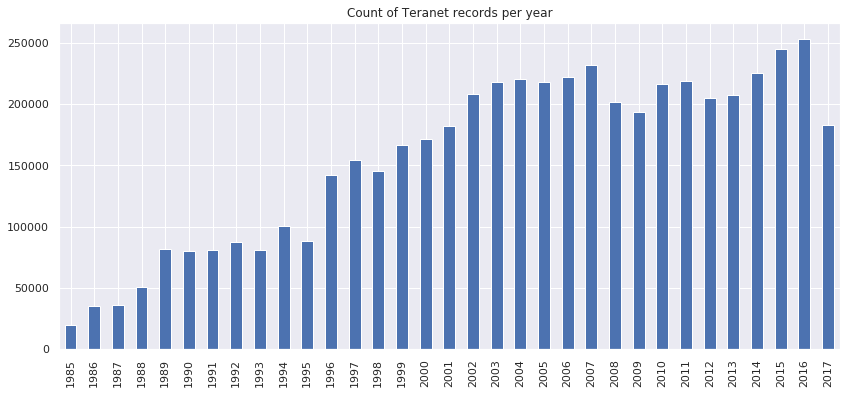

In [39]:
df = df.dropna(subset=['price_2016'])
print('{0:,} records in the subset.'.format(len(df)))
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(14, 6), title='Count of Teranet records per year');

## Filter out outliers: records with price > 2'000'000 CAD (in 2016 dollars)

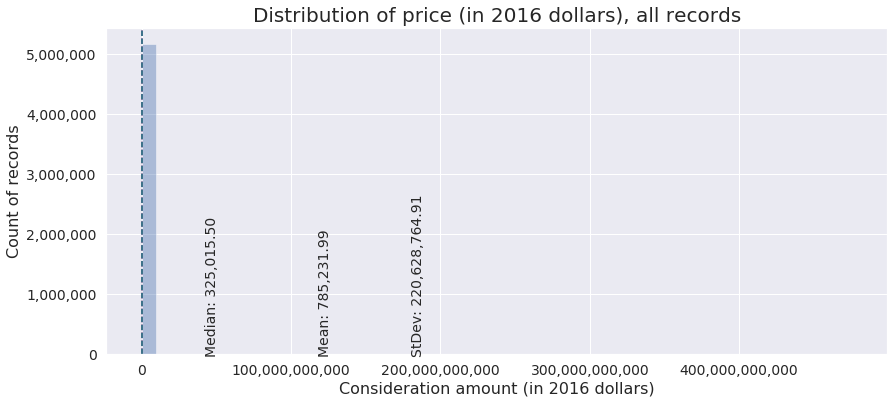

In [40]:
plot_hist(df['price_2016'], form_x=True, form_y=True, mean_xlift=150000, med_xlift=130000, sdev_xlift=230000,
          title='Distribution of price (in 2016 dollars), all records', x_label='Consideration amount (in 2016 dollars)')

In [41]:
max_price = 2000000
df2m = df.query('price_2016 < @max_price')
print('{0:,} records in the subset.'.format(len(df2m)))

5,052,925 records in the subset.


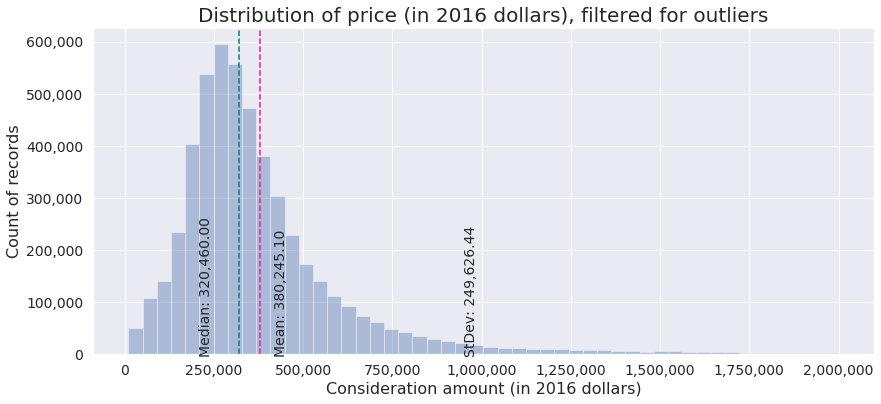

In [42]:
plot_hist(df2m['price_2016'], form_x=True, form_y=True, 
          title='Distribution of price (in 2016 dollars), filtered for outliers', 
          x_label='Consideration amount (in 2016 dollars)', med_xlift=0.65, sdev_xlift=2.5)

## Select the columns with variables

In [43]:
df.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'pin_price_pct_change',
       'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_next_6m', 'xy_sale_next_1y', 'xy_sale_next_3y', 'price_2016',
       'code'],
      dtype='objec

### Independent variables

#### `year`

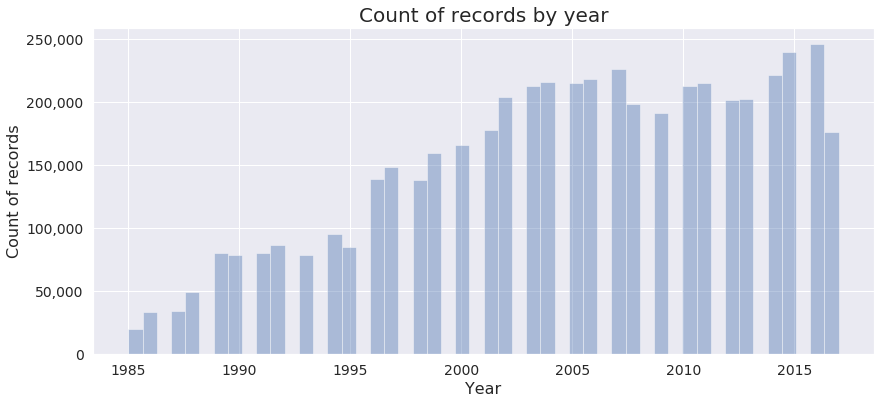

In [44]:
plot_hist(df2m['year'], form_y=True, 
          title='Count of records by year', plot_mean=False, plot_median=False, sdev=False,
          x_label='Year')

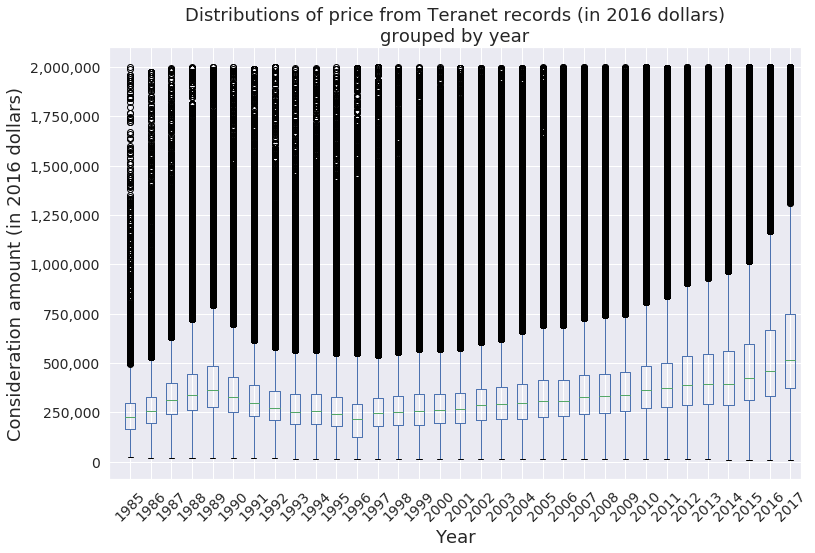

In [47]:
grouped_boxplot(df2m, group_col='year', vert=True, figsize=(12, 8), x_ticks_rot=45, form_y=True,
                xlabel='Year', ylabel='Consideration amount (in 2016 dollars)',
                title="Distributions of price from Teranet records (in 2016 dollars)\ngrouped by year")

### `code`, land use from geography department
Filtering out land uses with less than 10'000 Teranet records.

In [15]:
lu_counts = df2m['code'].value_counts()
mask_lu = lu_counts > 10000
lu10k = lu_counts[mask_lu].index

mask1 = df2m['code'].isin(lu10k)
s_lu = df2m[mask1]
print('{0:,} records in the subset.'.format(len(s_lu)))
s_lu['code'].value_counts()

4,773,494 records in the subset.


Single Detached House                          2125785
Apartments/Condos/Residence                    1088215
Strata Townhouses                               311874
Duplex/Semi-Detached                            242835
Townhouse                                       177257
Mix(Commercial Residential)                     164921
Underdeveloped Land                             147456
Mixed Complex (Residential, Office, Retail)     110934
Commercial/Shopping                              93275
Industrial/Employment Lands                      93015
Uncoded                                          70041
Parks                                            43931
Mixed Office with Retail                         34713
Streets                                          32267
Farmland                                         26542
Public/Structure Parking Lots                    10433
Name: code, dtype: int64

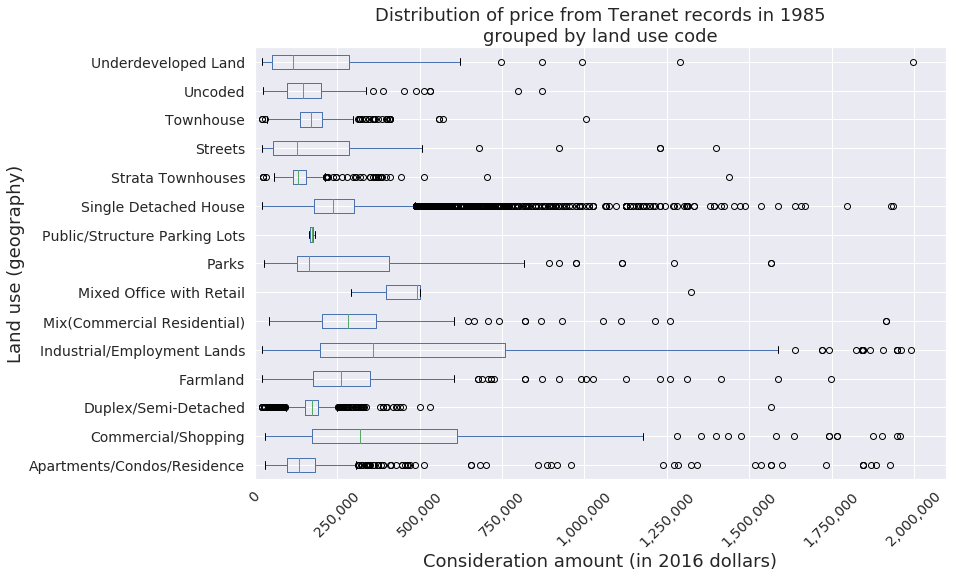

In [16]:
year = 1985
grouped_boxplot(s_lu, group_col='code', year=year,
                vert=False, figsize=(12, 8), x_ticks_rot=45, form_x=True,
                xlabel='Consideration amount (in 2016 dollars)', ylabel='Land use (geography)',
                title='Distribution of price from Teranet records in {0}\ngrouped by land use code'.format(year))

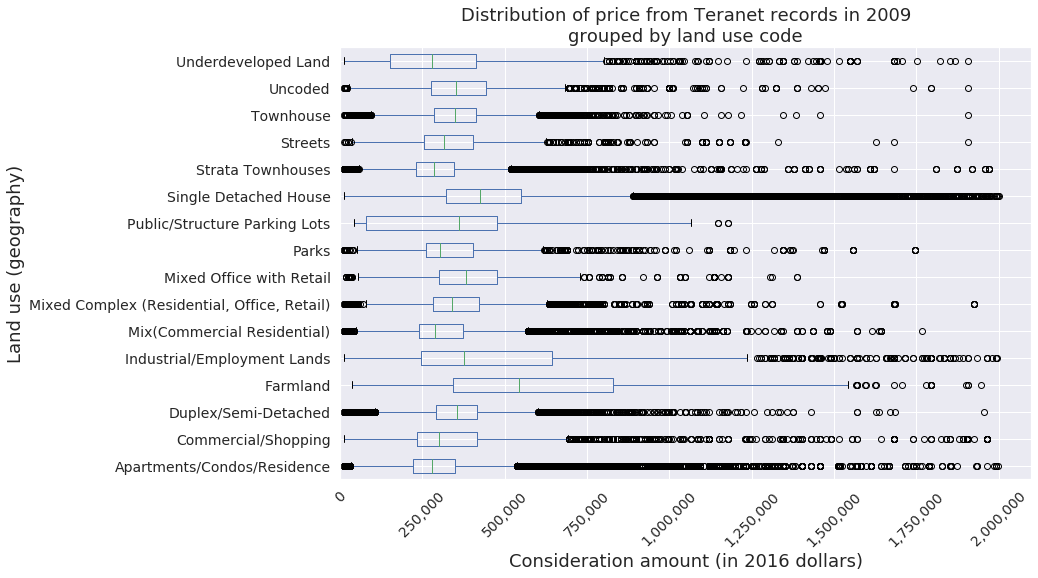

In [17]:
year = 2009
grouped_boxplot(s_lu, group_col='code', year=year,
                vert=False, figsize=(12, 8), x_ticks_rot=45, form_x=True,
                xlabel='Consideration amount (in 2016 dollars)', ylabel='Land use (geography)',
                title='Distribution of price from Teranet records in {0}\ngrouped by land use code'.format(year))

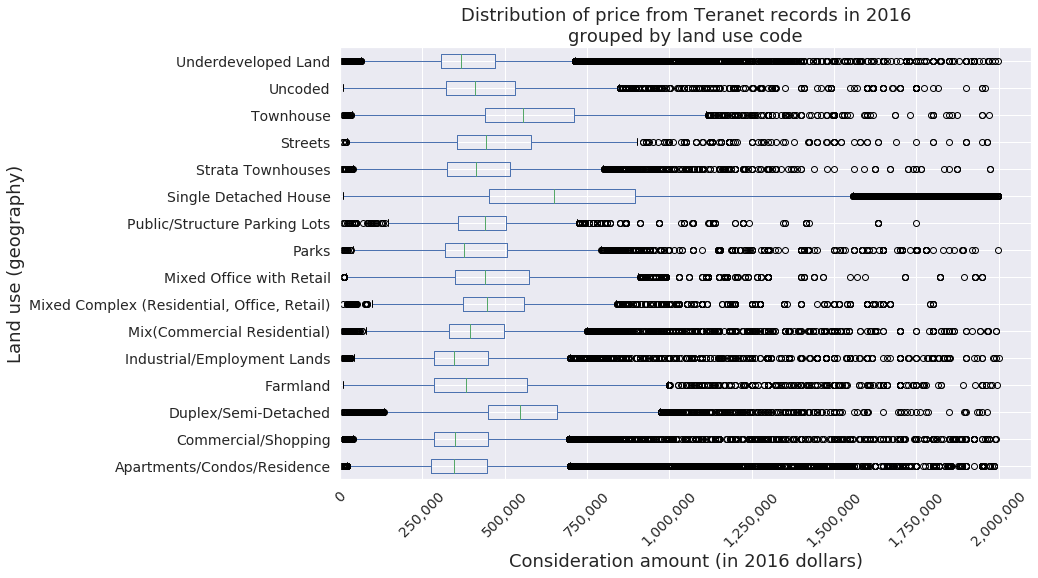

In [18]:
year = 2016
grouped_boxplot(s_lu, group_col='code', year=year,
                vert=False, figsize=(12, 8), x_ticks_rot=45, form_x=True,
                xlabel='Consideration amount (in 2016 dollars)', ylabel='Land use (geography)',
                title='Distribution of price from Teranet records in {0}\ngrouped by land use code'.format(year))

#### `pin_total_sales`

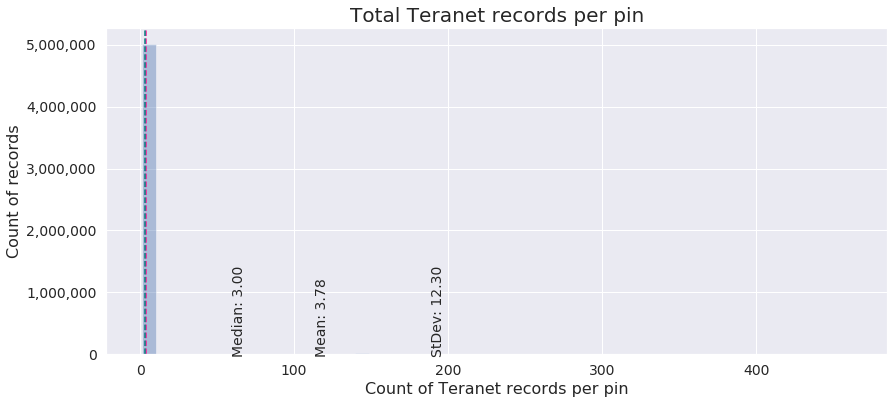

In [19]:
plot_hist(df2m['pin_total_sales'], form_y=True, form_x=True,
          title='Total Teranet records per pin', mean_xlift=30, med_xlift=20, sdev_xlift=50,
          x_label='Count of Teranet records per pin')

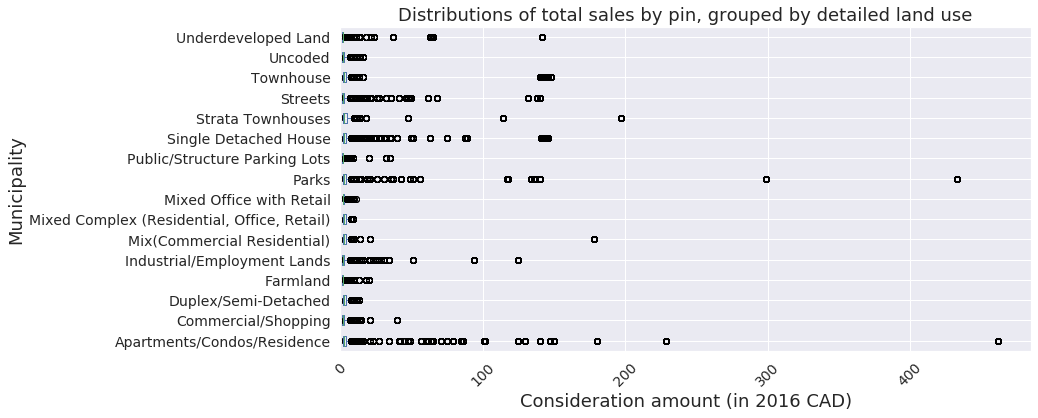

In [20]:
grouped_boxplot(s_lu, plot_col='pin_total_sales', group_col='code', 
                vert=False, figsize=(12, 6), x_ticks_rot=45, form_x=True,
                title='Distributions of total sales by pin, grouped by detailed land use')

##### Filter out outliers, records with over 10 sales per pin

In [22]:
s_pin = df2m.query('pin_total_sales < 10')
print('{0:,} records in the subset.'.format(len(s_pin)))

5,014,344 records in the subset.


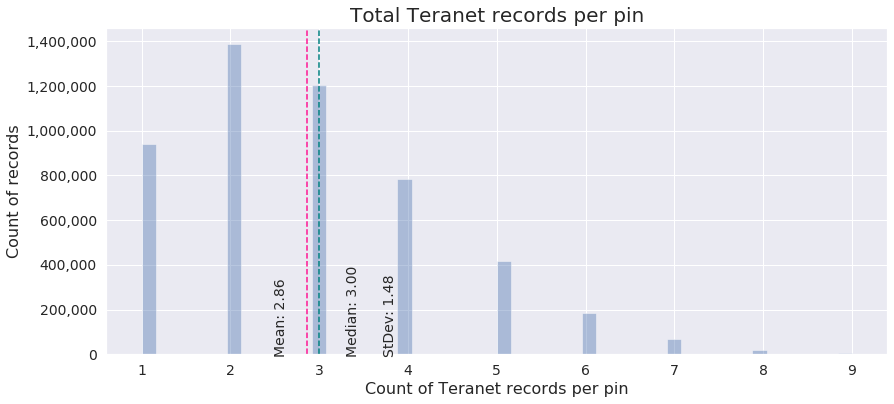

In [23]:
plot_hist(s_pin['pin_total_sales'], form_y=True, form_x=True,
          title='Total Teranet records per pin', med_xlift=1.1, mean_xlift=0.87,
          x_label='Count of Teranet records per pin')

#### `xy_total_sales`

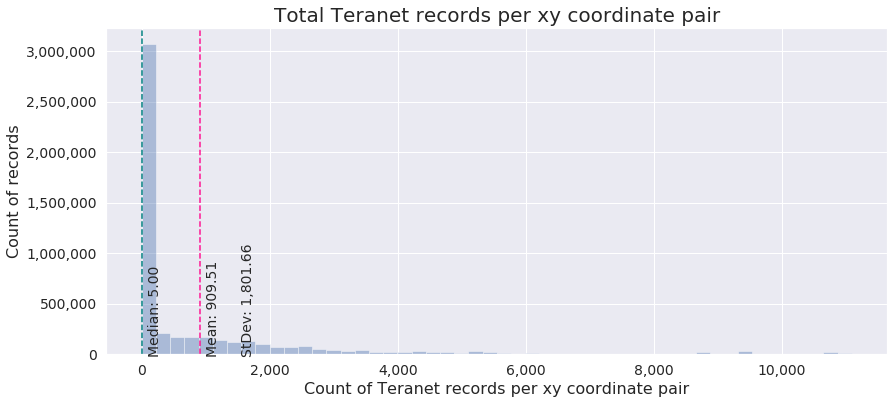

In [24]:
plot_hist(df2m['xy_total_sales'], form_y=True, form_x=True,
          title='Total Teranet records per xy coordinate pair', mean_xlift=1.1, med_xlift=20, sdev_xlift=1.7,
          x_label='Count of Teranet records per xy coordinate pair')

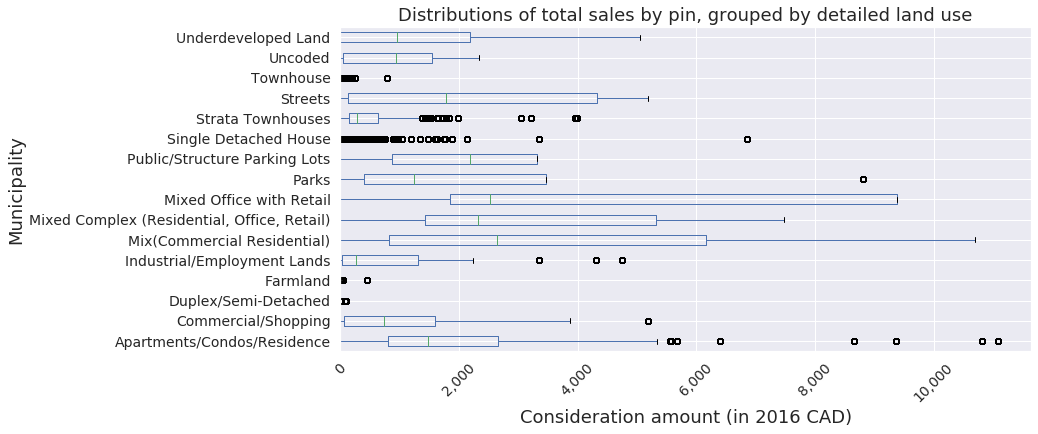

In [25]:
grouped_boxplot(s_lu, plot_col='xy_total_sales', group_col='code', 
                vert=False, figsize=(12, 6), x_ticks_rot=45, form_x=True,
                title='Distributions of total sales by pin, grouped by detailed land use')

## Boxplots by year for townhouses vs all property types

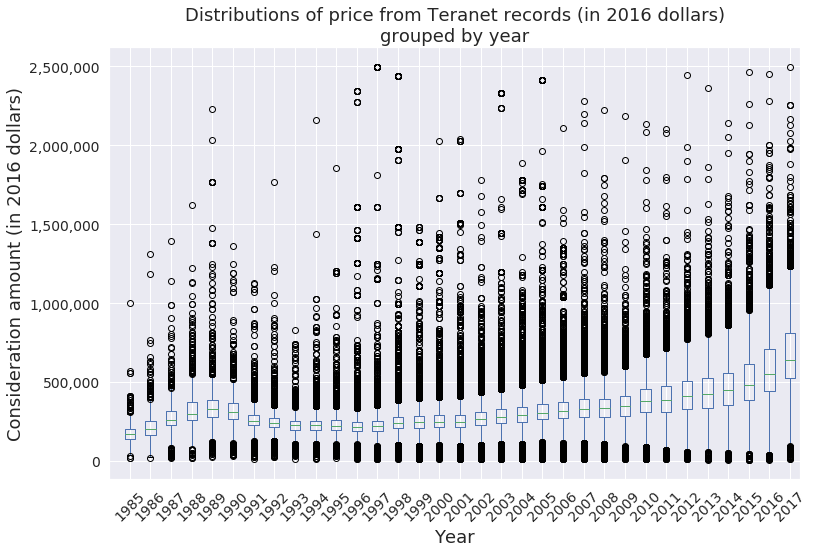

In [26]:
mask1 = df['code'] == 'Townhouse'
mask2 = df['xy_total_sales'] < 10
mask3 = df['price_2016'] < 2500000
s = df[mask1 & mask2 & mask3]
grouped_boxplot(s, group_col='year', vert=True, figsize=(12, 8), x_ticks_rot=45, form_y=True,
                xlabel='Year', ylabel='Consideration amount (in 2016 dollars)',
                title="Distributions of price from Teranet records (in 2016 dollars)\ngrouped by year")

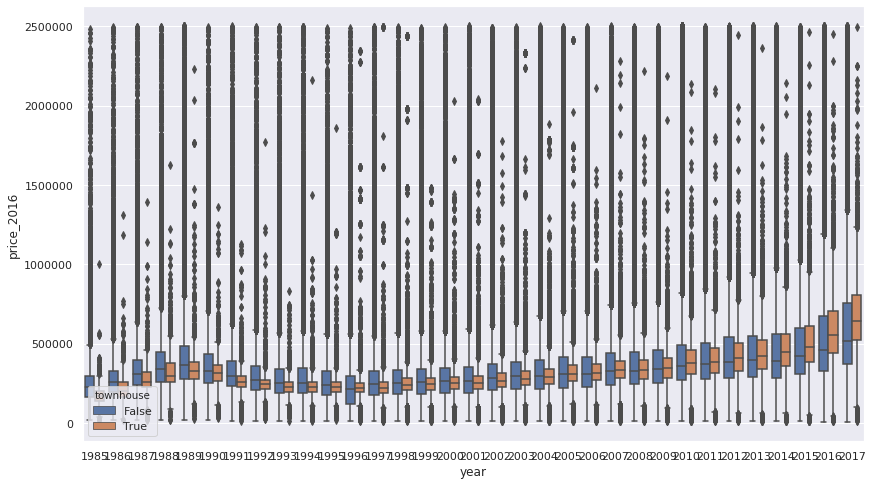

In [31]:
mask1 = df['code'] == 'Townhouse'
mask2 = df['xy_total_sales'] < 10
mask3 = df['price_2016'] < 2500000
df.loc[mask1 & mask2 & mask3, 'townhouse'] = True
df['townhouse'] = df['townhouse'].fillna(False)
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('price_2016 < 2500000'), x='year', y='price_2016', hue='townhouse', ax=ax)
plt.show()

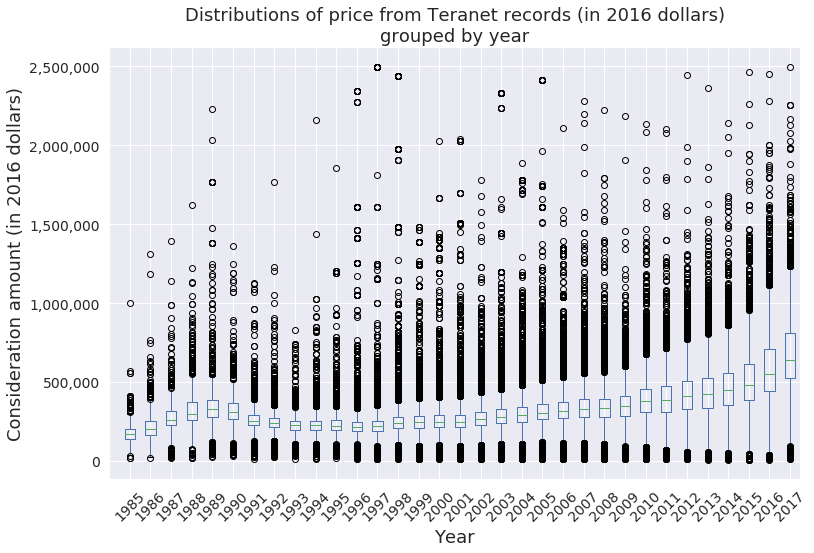

In [260]:
mask1 = df['code'] == 'Townhouse'
mask2 = df['xy_total_sales'] < 10
mask3 = df['price_2016'] < 2500000
s = df[mask1 & mask2 & mask3]
grouped_boxplot(s, group_col='year', vert=True, figsize=(12, 8), x_ticks_rot=45, form_y=True,
                xlabel='Year', ylabel='Consideration amount (in 2016 dollars)',
                title="Distributions of price from Teranet records (in 2016 dollars)\ngrouped by year")

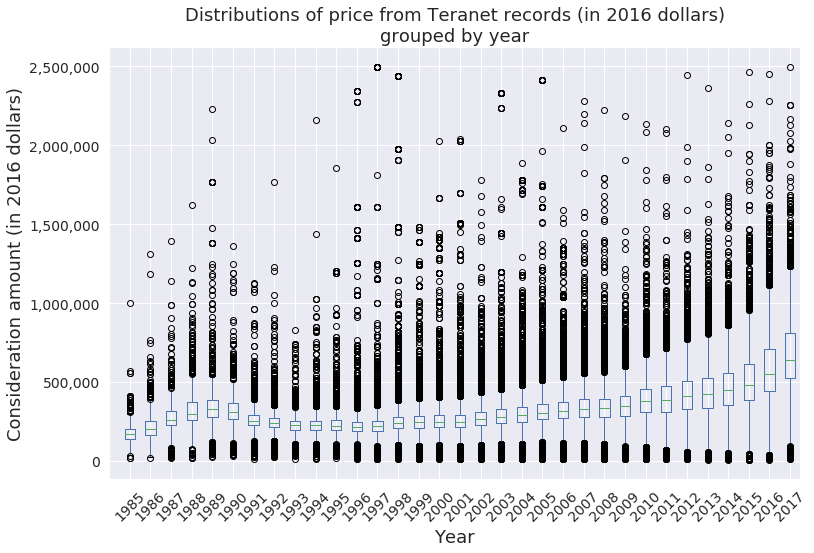

In [260]:
mask1 = df['code'] == 'Townhouse'
mask2 = df['xy_total_sales'] < 10
mask3 = df['price_2016'] < 2500000
s = df[mask1 & mask2 & mask3]
grouped_boxplot(s, group_col='year', vert=True, figsize=(12, 8), x_ticks_rot=45, form_y=True,
                xlabel='Year', ylabel='Consideration amount (in 2016 dollars)',
                title="Distributions of price from Teranet records (in 2016 dollars)\ngrouped by year")

#### `pin_prev_sales` and `xy_prev_sales` follow similar distributions, highly correlated with `total_sales` variables

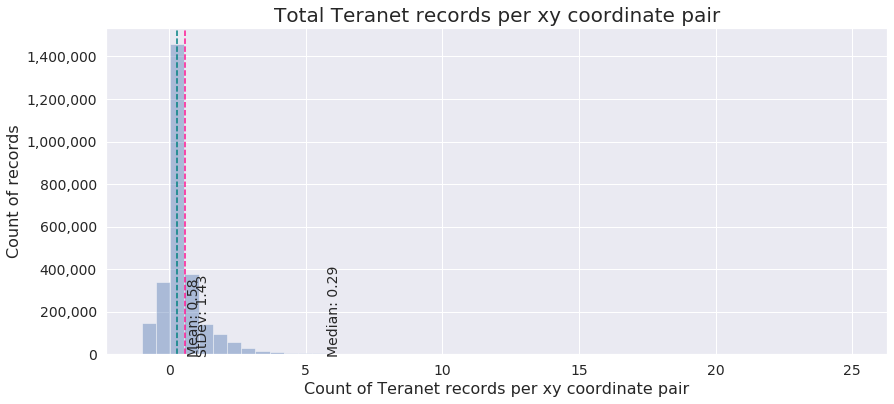

In [181]:
col = 'pin_price_pct_change'
min_value = 25
plot_hist(df2m.dropna(subset=[col]).query('{0} < {1}'.format(col, min_value))[col], form_y=True, form_x=True,
          title='Total Teranet records per xy coordinate pair', mean_xlift=1.1, med_xlift=20, sdev_xlift=1.7,
          x_label='Count of Teranet records per xy coordinate pair')